# Multi density clustering for evolving datastream
- [Grid](#Grid)
- [Offline Phase](#Offline-Phase)
- [Online Phase](#Online-Phase)
- [Model starts working here](#Working)

In [1]:
__author__='Black D Chase,MR-TLL'
__version__='0.0.1'  

In [2]:
#Imports
import matplotlib.pyplot as plt
import torch
from math import ceil,log2
import log
import random

In [3]:
## Globals - hyperparameters
"""
0 < alpha < 1
lambda > 0
optimal gridGranuality 20 to 30
Data is min normalised b/w [mini,maxi]

minPts is min. required neighbors around a grid (for min point DBSCAN)
"""
lamda = 0.12
log.info(f"Lambda = {lamda}")
gridGranuality = 30
log.info(f"gridGranuality = {gridGranuality}")
dimension = 2
log.info(f"Dimension = {dimension}")
mini = 0
maxi = 9999
log.info(f"ValueRange = {mini}-{maxi}")
alpha = 0.2
log.info(f"alpha = {alpha}")
factor = (maxi-mini+1)/gridGranuality
log.info(f"Factor = {factor}")

N = factor**dimension
log.info(f"N = {N}")

w_cmc = alpha/(1-2**(-lamda))
log.info(f"Min weight for CMC = {w_cmc}")

minPts = int(2**(dimension*3/4)) 
log.info(f"Min number of cmc for Cluster = {minPts}")

t_pt = ceil(1/(lamda*log2(alpha/(alpha-1+2**(-lamda)))))
log.info(f"Pruning Time = {t_pt}")

# DataPoint

In [4]:
class DataPoint:
    def __init__(self,val,t):
        # val is tuple
        self.position = val
        # t is timestamp
        self.t = t
    def __floordiv__(self,divident):
        return tuple([i//divident for i in self.position])
    def print(self):
        print(self.position, self.t)
    

In [5]:
'''
Importing dataset and converting to stream
'''
stream = []
with open('dataset/multiple_dataset_merged_to_stream.txt') as file:
    t = 1
    for line in file:
        line = line[:-1]
        b = line.split('\t')
        batch=[]
        for j in b:
            d = DataPoint(list(map(float, j.split(','))), t)
            batch.append(d)
        stream.append(batch)
        t+=1

# for batch in stream:
#     for item in batch:
#         item.print()
        
stream.append(None)

# Grid
- Region of space which could contain points
- Grid can be:
    - Sporadic Grid $[0]$:
        Region of space which does not contain points
    - Normal Grid $[1]$:
        Region of space which contain points
    - Core Mini Cluster $[2]$:
        Region of space which contains significatn number of points that it could be called as a mini cluster $cmc$

In [6]:
class Grid:
    gType=["Sporadic","Normal","CMC"]
    global alpha,N,lamda,w_cmc,factor,dimension,mini,maxi
    def __init__(self,location,):
        self.location = location
        self.n = 0
        self.t = 0
        self.w = 0
        self.mcd = None
        self.c = None
        self.status = 0
        # hash to be a tuple
        self.storage = []
        self.visited = False
        self.cluster = None
    
    def __hash__(self):
        return hash(self.location)
    
    #""" Might Not need this
    def __eq__(self,other):
        if type(other) == type(self):
            return self.location==other.location
        return self.location==other
    #"""
    def __iter__(self):
        return iter(self.storage)
    
    def updateGS(self,t):
        self.n+=1
        self.w=self.w*2**(-1*lamda*(t - self.t))+1
        self.t=t
        log.debug(f"number of points of {self.n}")
        log.debug(f"weight of the grid {self.w}")
        log.debug(f"updated time {self.t}")
        pass
    
    def calMCD(self):
        mcd=0
        for point in self:
            mcd=max(mcd,self.getDistance(point))
        return mcd
    
    def calCenter(self,time):
        ## time is the current time at the calculation of the center.
        center=[0 for i in range(dimension)]
        assert(self.w!=0) 
        ## weight must be non-zero for cmc center calc.

        for points in self:
            timestamp=points.t
            weight=2**(-1*lamda*(time - timestamp))
            tmplst=[]
            for dims in range(dimension):
                tmplst.append(weight*points.position[dims])
            for idx in range(dimension):
                center[idx]+=tmplst[idx]

        for idx in range(dimension):
            center[idx]=center[idx]/(self.w)
        self.c=center
        return center

    def calRadius(self,time):
        radius=0
        assert(self.w!=0) ## weight must be non-zero for cmc center calc.
        for points in self:
            timestamp=points.t
            weight=2**(-1*lamda*(time - timestamp))
            numerator=(weight*self.getDistance(points,self.c))
            radius+=numerator

        radius/=self.w
        self.r=radius
        return radius
    
    def addPoint(self,point):
        self.storage.append(point)
        self.updateGS(point.t)
        
    def getDistance(self,point):
        dist=sum(map(lambda x,y: (x-y)**2,point.position,self.c))**(0.5)
        return dist
    
    def __flush(self):
        """
        Sporadic
        Will be deleted to make room
        """
        self.status = 0 
    
    def __makeitGrid(self):
        """
        Normal
        Will now be a normal grid
        """
        self.status = 1
        
    def __makeitCMC(self,t):
        """
        Core Mini Cluster
        Will now be considered as a mini cluster
        """
        self.calCenter(t)
        self.calMCD()
        """Calculating but never using it
        self.calRadius(t)
        #"""
        
        self.status = 2
    
    def __getOWT(self,t):
        OWT = alpha*(1-2**(-lamda*(self.t-t+1)))/(N*(1-2**(-lamda*t)))
        return OWT
    
    def updateStatus(self,t):
        if self.n>1 and self.w>w_cmc:
            self.__makeitCMC(t)
        elif self.w<self.__getOWT(t) or self.n<1:
            self.__flush()
        else:
            self.__makeitGrid()
        return self.status
    
    pass

## Grid Conditions
- Grid weight:
   $$
      W_g(t_c) = \sum_{x \subset g} 2^{-\lambda * (t_c - t_x )}
   $$
   
- Grid weight Update:
   $$
      W_g(t_p,t_c) = 2^{-\lambda * (t_c - t_x )}* w_g(t_p) + 1
   $$
   
- Maximum possible theoretrical Weight of all data points:
   $$
   w_{max} = \frac{1}{1-2^{-\lambda}}
   $$
   
- Time Quantum for Grid and CMC updates 
   $$
   t_{pt} = \frac{log_{2}{\big(\frac{\alpha}{\alpha - N(1-2^{- \lambda})}\big)}}{\lambda}
   $$
   
- Grid->CMC condition:
    $$
      n_g > 1 \text{ and } w_g \ge \frac{\alpha}{N(1-2^{-\lambda})}
    $$

- OWT parameter for GRID and CMC Updates with time  ::

    If $W_g < OWT$ --> remove grid from grid list.
    $$
      OWT(t_c,t_p) = \frac{\alpha(1-2^{-\lambda(t_c - t_p +1)})}{N(1-2^{-\lambda*t_p})}
    $$
    
## CMC Conditions
- Parameters Of CMC when a grid is promoted to CMC:
  $$
  W_{cmc} = W_{g}
  $$
  
  $$
  C_{cmc} = \frac{\sum_{1}^{n} f(t_c - t_i)(p_i)}{w_{cmc}}
  $$
  
  $$
  r_{cmc} = \frac{\sum_{1}^{n} f(t_c - t_i)(distance(p_{ij},c_{cmc}))}{w_{cmc}}
  $$

- If $ W_{cmc} <  \frac{\alpha}{N(1-2^{-\lambda})} $
   Then remove cmc from cmc list

# Cluster
- Combination of one or more mini clusters
- Cluster can be
    - Neighboring grid : $N_g$ for $cmc_p$
    - MinPts-nearest-neighbors : $N_{sh}(cmc_q)$ for a $cmc_p$
    - Core-neighboring :  A core mini-cluster with its MinPts-nearest-neighbors become core-neighboring $N_{core}$ for a $N_{sh}(cmc_p)$

In [7]:
class Cluster:
    global alpha,N,lamda,w_cmc,factor,dimension,mini,maxi,minPts
    def __init__(self,name="Unwanted"):
        self._cmcList = {}
        self.name = name
        
    def __eq__(self,other):
        return self.name==other.name
        
    def __hash__(self):
        return hash(self.name)
        
    def __iter__(self):
        return iter(self._cmcList)
    
    def __len__(self):
        return len(self._cmcList)
    
    def has(self,cmc):
        return cmc in self._cmcList.keys()
    
    def getGrid(self,cmc):
        return self._cmcList[cmc]
    
    def addGrid(self,cmc):
        if cmc not in self._cmcList:
            cmc.cluster=self.name
            self._cmcList[cmc]=cmc
            log.debug(f"{cmc} belongs to {self.name}")
    
    def union(self,cluster):
        l = len(self)
        for cmc in cluster:
            self.addGrid(cluster.getGrid(cmc))
        log.debug(f"Length of cluster in union {l}->{len(self)}")
        
    def sigma(self,cmc_center,minpts_neighbours):
        mean=self.mu(cmc_center,minpts_neighbours)

        ## minpts_neighbours is a list of all cmc which are kNN to the cmc_center.
        ## Now we will calculate the standard deviation of the distances from these KNN
        distance_list=[]
        length=dimension
        
        for grid in minpts_neighbours:
            dst=0.0
            distance_list.append(
                minpts_neighbours._cmcList[grid].getDistance(DataPoint(cmc_center,0))
            )

        sd=0.0
        for dist in distance_list:
            sd+=(dist - mean)**(2)
        sd/=len(distance_list)
        sd=sd**(0.5)
        log.debug(f"Sigma for {cmc_center} is {sd}")
        return sd
    
    def mu(self,cmc_center,minpts_neighbours):
        ## minpts_neighbours is a list of all cmc which are kNN to the cmc_center.
        ## Now we will calculate the mean of the distances from these KNN
        distance_list=[]
        length=dimension
        
        for grid in minpts_neighbours:
            dst=0.0
            distance_list.append(
                minpts_neighbours._cmcList[grid].getDistance(DataPoint(cmc_center,0))
            )
        
        mean=0.0
        for i in distance_list:
            mean+=i
        mean/=len(distance_list)
        log.debug(f"Mu for {cmc_center} is {mean}")
        return mean        

# Clusterer

In [8]:
class Clusterer:
    global alpha,N,lamda,w_cmc,factor,dimension,mini,maxi,minPts,t_pt
    def __init__(self):
        self._gridList={} ## list which containg all the grids as objects.
        self.ng=0 ## no of grids made till now
        pass
    
    def _updateGrid(self,grid,t):
        """
        If a grid is empty, remove it
        #"""
        grid.updateStatus(t)
        log.debug(f"{grid.location} status = {grid.status}")
        log.debug(f"{grid.location} n,w = {grid.n},{grid.w}")
        if grid.status==0:
            sporadic = self._gridList.pop(grid)
            log.debug(f"Popped {sporadic.location}")
            del sporadic
    
    def _findGrid(self, point):
        """
        if a point is (x,y) this it belongs to location (x//factor,y//factor)
        This locataion is the name of grid it will be assigned to
        #"""
        loc = point//factor
        if loc not in self._gridList:
            self._makeGrid(loc)
        return self._gridList[loc]
    
    def _makeGrid(self, loc):
        """
        If grid is not created or deleted to save space recreate it
        #"""
        self._gridList[loc] = Grid(loc)
        log.debug(f"Grid opened at {loc}")
        
    def getCMC(self):
        cmc_S = []
        for grid in self._gridList:
            if self._gridList[grid].status == 2:
                cmc_S.append(self._gridList[grid])
        return cmc_S
    pass

# Online Phase

- CMC-Grid-Neighbourhood
    $$
     {N_g(cmc)} \leftarrow \forall  cmc_p \epsilon {N_g}
    $$
- MinPts nearest Neighbours: In order to determine
- MinPts-nearest-neighbor for the cmc_p, firstly the distance from cmc_p is calculated from all cmc_p-grid-neighborhoods.
- After that, MinPts neighbors are selected with minimum distances and form shorted list neighbors

$$
{N_{sh}(cmc_q)} \leftarrow Minimum(distance((cmc_p),{N_g(cmc_p)}), |N_{sh}(cmc_q)| \ge MinPts
$$

- Core-Neighbouring: A core mini cluster with its MinPts-nearestr-neighbours becomes a core-neighbouring if following conditions are satisfied:

    $$
 {N_{core}} \leftarrow \forall  cmc_q \epsilon {N_{sh}(cmc_p)}
    $$
    
    $$
 \mu(Dist_{cmc_q}) \epsilon [\mu(Dist_{core}) - \sigma(Dist_{core}),\mu(Dist_{core}) + \sigma(Dist_{core})]
    $$
    
    $$
    \mu(Dist_{core}) \leftarrow \mu(distance(N_{sh}(cmc_p),cmc_p)
    $$
    
    $$
    \sigma(Dist_{core}) \leftarrow \sigma(distance(N_{sh}(cmc_p),cmc_p)
    $$
    
    $$
     \mu(Dist_{cmc_q}) \leftarrow \mu(distance(N_{sh}(cmc_q),cmc_q)
    $$
    
    $$
    \sigma(Dist_{cmc_q}) \leftarrow \sigma(distance(N_{sh}(cmc_q),cmc_q)
    $$
    

In [9]:
class Online(Clusterer):
    log.info(f"Lambda = {lamda}")
    log.info(f"gridGranuality = {gridGranuality}")
    log.info(f"Dimension = {dimension}")
    log.info(f"ValueRange = {mini}-{maxi}")
    log.info(f"Factor = {factor}")
    log.info(f"N = {N}")
    log.info(f"alpha = {alpha}")
    log.info(f"Min weight for CMC = {w_cmc}")
    log.info(f"Pruning Time = {t_pt}")
    def __init__(self):
        super(Online,self).__init__()
        pass        
        
    def streamData(self,data):
        t=0
        # Time passed
        while(True):
            t+=1
            newPoints = data[t-1]
            """
            []                      : This time step recived no points
            [DataPoint1,DataPoint2] : This time step recived 2 datapoints
            None                    : This marks end of time steps
            #"""
            if newPoints==None:
                break
            for point in newPoints:
                
                grid = self._findGrid(point)
                """
                Grid could be sporadic, normal or cmc
                point will be added 
                #"""
                grid.addPoint(point)
                self._updateGrid(grid,t)
                    
            if t%t_pt==0:
                """
                Pruning, after every t_pt timestep
                #"""
                for grid in self._gridList.values():
                    self._updateGrid(grid,t)    
    pass

# Offline Phase

In [10]:
class Offline(Clusterer):
    log.info(f"Lambda = {lamda}")
    log.info(f"gridGranuality = {gridGranuality}")
    log.info(f"Dimension = {dimension}")
    log.info(f"ValueRange = {mini}-{maxi}")
    log.info(f"Factor = {factor}")
    log.info(f"N = {N}")
    log.info(f"alpha = {alpha}")
    log.info(f"Min weight for CMC = {w_cmc}")
    log.info(f"Pruning Time = {t_pt}")
    
    def __init__(self):
        super(Offline,self).__init__()
        self.clusters = {}
        self.counter=-1
        pass
    
    def uploadCMC(self,cmcList):
        for cmc in cmcList:
            cmc.visited=False
            self._gridList[cmc]=cmc
        log.debug(f"cmc length = {len(self._gridList.keys())}")
    
    def getNeighbours(self,cmc):
        loc = cmc.location
        l=[]
        for i in range(len(loc)): 
            x = list(loc) 
            y = list(loc) 
            x[i]-=1 
            y[i]+=1 
            l.append(tuple(x)) 
            l.append(tuple(y))
        n_g = Cluster()
        n_g.status = 1
        for grid in l:
            if grid in self._gridList:
                n_g.addGrid(self._gridList[grid])
        log.debug(f"{cmc} has {len(n_g)}")
        return n_g
    
    def getName(self):
        self.counter+=1
        return self.counter
    
    def findMPNN(self,n_g,cmc_p):

        ## n_g is class of all the neighbours , cmc_p is the center of current cmc..
        ## now find minPts nearest neighbours in n_g.
        k_list=[]
        for cmc in n_g:
            k_list.append([cmc_p.getDistance(DataPoint(cmc.c,0)),cmc])

        k_list.sort(key = lambda x: x[0])
        clus=Cluster()
        for idx in range(minPts):
            clus.addGrid(self._gridList[k_list[idx][1]])
        
        return clus

    def mergeClusters(self):
        keys = list(self._gridList.keys())
        random.shuffle(keys)
        for i in keys:
            cmc_p = self._gridList[i]
            if not cmc_p.visited:
                cmc_p.visited = True
                n_gp = self.getNeighbours(cmc_p)
                
                if len(n_gp)>=minPts:
                    c = Cluster(self.getName())
                    c.addGrid(cmc_p)
                    self.clusters[c]=c
                    n_core = self.findMPNN(n_gp,cmc_p)
                    mu_p,sigma_p = n_core.mu(cmc_p.c,n_core),n_core.sigma(cmc_p.c,n_core)
                    
                    while(len(n_core)>0):
                        q = list(n_core._cmcList.keys())[0]
                        cmc_q = n_core._cmcList.pop(q)
                        if not cmc_q.visited:
                            cmc_q.visited = True
                            n_gq = self.getNeighbours(cmc_q)
                            
                            if len(n_gq)>=minPts:
                                n_sh = self.findMPNN(n_gq,cmc_q)
                                mu_q = n_sh.mu(cmc_q.c,n_sh)
                                
                                if mu_p-sigma_p <=mu_q<= mu_p+sigma_p:
                                    n_core.union(n_sh)
                                    mu_p,sigma_p = n_core.mu(cmc_p.c,n_core),n_core.sigma(cmc_p.c,n_core)
                        if cmc_q.cluster is None:
                            c.addGrid(cmc_q)
                else:
                    cmc_p.cluster="NOISE"
                    
    def getClusters(self):
        return self.clusters
    
    pass

# Working

In [11]:
online_component = Online()
online_component.streamData(stream)
cmc_list = online_component.getCMC()
len(cmc_list)

159

In [12]:
offline_component = Offline()
offline_component.uploadCMC(cmc_list)
offline_component.mergeClusters()
clusters = offline_component.getClusters()                                                                                                                                                                              
len(clusters)

38

In [13]:
for i in clusters:
    print(i.name)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


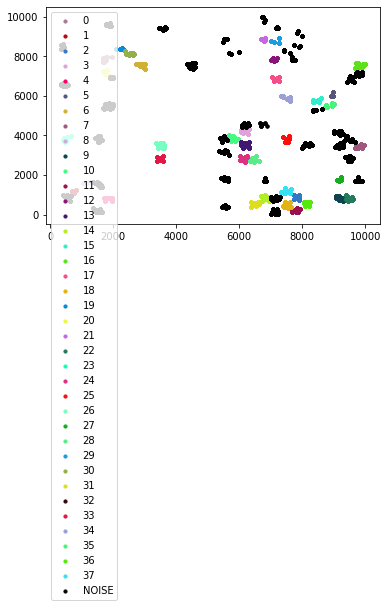

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

for cluster in clusters:
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    x=[]
    y=[]
    cmcs = cluster._cmcList
    for cmc in cmcs:
        for points in cmc.storage:
            x.append(points.position[0])
            y.append(points.position[1])
    ax.scatter(x, y, s=10, c=color, label=cluster.name)
x=[]
y=[]
for cmc in cmc_list:
    if cmc.cluster=='NOISE':
        for points in cmc.storage:
            x.append(points.position[0])
            y.append(points.position[1])
ax.scatter(x, y, s=10, c='k', label='NOISE')
plt.legend(loc='upper left');
plt.show()